
# Testing our Model

In [12]:
import warnings
warnings.filterwarnings('ignore')
import os
import json
import numpy as np
import pandas as pd
import skimage.draw
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import Mask RCNN
from mrcnn import utils
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

In [13]:
# Root directory of the project
ROOT_DIR = r"D:\Final Year Project\0000_CODE"

# Directory to save logs and model checkpoints
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")


WEIGHTS_PATH = r"D:\Final Year Project\0000_CODE\logs\object20220421T1328\mask_rcnn_object_0010.h5"

In [14]:
############################################################
#  Configuration for training on our custom dataset.
#  Derives from the base Config class and overrides some values.
############################################################
class CustomConfig(Config):
    # Configuration name
    NAME = "object"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 6  # Background + 6 classes

    # Skip detections with < 51% confidence
    DETECTION_MIN_CONFIDENCE = 0.51

In [15]:
#####################################################################################
#  Customising the Dataset class in Mask R-CNN utilities with our Custom Dataset
#####################################################################################

class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """
        Loading a subset of our Dataset (Train/Val)

        dataset_dir: Root directory of the dataset.
        subset:      Subset to load: train or val
        """
        # Adding the 6 classes.
        self.add_class("object", 1, "person")
        self.add_class("object", 2, "rider")
        self.add_class("object", 3, "car")
        self.add_class("object", 4, "bus")
        self.add_class("object", 5, "truck")
        self.add_class("object", 6, "electric auto")

        # Validating subset to load
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations1 = json.load(open(r"D:\Final Year Project\0000_CODE\Dataset\train\final_train.json"))
        annotations = list(annotations1.values())

        if(subset == "val"):
            annotations1 = json.load(open(r"D:\Final Year Project\0000_CODE\Dataset\val\val-json.json"))
            annotations = list(annotations1.values())

        # Skipping un-annotated images
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            
            #Getting the object boundary coordinates from the annotation json file
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)

            name_dict = {"person": 1,"rider": 2,"car": 3,"bus": 4,"truck": 5,"electric auto": 6}

            num_ids = [name_dict[a] for a in objects]
            print("numids",num_ids)

            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)

            # load_mask() needs the image size to convert polygons to masks.
            height, width = image.shape[:2]

            #Adding the image
            self.add_image(
                "object",
                image_id=a['filename'],
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """
        Generate instance masks for an image.

       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """

        # Converting the polygons to a bitmap mask of shape [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Getting indexes of pixels inside the polygon and setting them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
        	mask[rr, cc, i] = 1

         
        # Mapping class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)

        # Returning the mask, and array of class IDs of each instance.
        return mask, num_ids

    def image_reference(self, image_id):
        # Returns the path of the image.
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [16]:
# For visualization purposes
def get_ax(rows=1, cols=1, size=16):
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

In [17]:
# Loading the validation dataset
CUSTOM_DIR = r"D:\Final Year Project\0000_CODE\Dataset"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

objects: ['car']
numids [3]
objects: ['car']
numids [3]
objects: ['car']
numids [3]
objects: ['car']
numids [3]
objects: ['car']
numids [3]
objects: ['car']
numids [3]
objects: ['car']
numids [3]
objects: ['car']
numids [3]
objects: ['car']
numids [3]
objects: ['car']
numids [3]
objects: ['person']
numids [1]
objects: ['person']
numids [1]
objects: ['person']
numids [1]
objects: ['person']
numids [1]
objects: ['person']
numids [1]
objects: ['person']
numids [1]
objects: ['person']
numids [1]
objects: ['person', 'person']
numids [1, 1]
objects: ['person']
numids [1]
objects: ['person']
numids [1]
objects: ['rider']
numids [2]
objects: ['rider']
numids [2]
objects: ['rider']
numids [2]
objects: ['rider']
numids [2]
objects: ['rider']
numids [2]
objects: ['rider']
numids [2]
objects: ['rider']
numids [2]
objects: ['rider']
numids [2]
objects: ['rider']
numids [2]
objects: ['rider']
numids [2]
objects: ['bus']
numids [4]
objects: ['bus']
numids [4]
objects: ['bus']
numids [4]
objects: ['bu

In [18]:
#Loading model in inference mode
config = CustomConfig()
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

In [19]:
# Loading weights of the model we trained
weights_path = WEIGHTS_PATH
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  D:\Final Year Project\0000_CODE\logs\object20220421T1328\mask_rcnn_object_0010.h5
Re-starting from epoch 10


Processing 1 images
image                    shape: (575, 1024, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


array([[[255, 255, 251],
        [255, 255, 253],
        [255, 254, 255],
        ...,
        [255, 255, 250],
        [255, 255, 251],
        [255, 255, 253]],

       [[255, 255, 253],
        [255, 255, 253],
        [255, 254, 255],
        ...,
        [255, 255, 250],
        [255, 255, 253],
        [255, 255, 253]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 254, 255],
        ...,
        [255, 255, 250],
        [255, 255, 253],
        [255, 255, 255]],

       ...,

       [[255, 255, 253],
        [255, 255, 253],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 253],
        [255, 255, 253]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 253],
        [255, 255, 253]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 253],
        [255, 255, 253]]

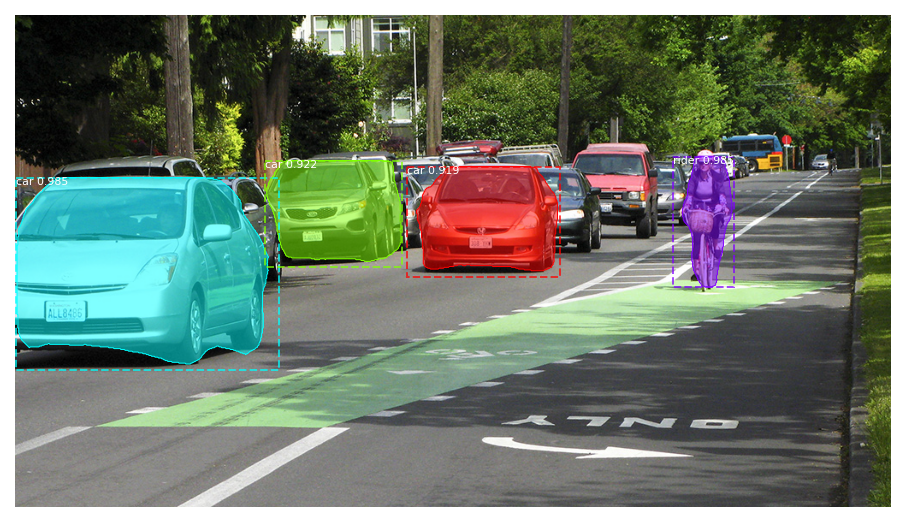

In [20]:
# Testing our model on new images
path_to_new_image = r"D:\Final Year Project\codebase\test images\Advocacy_Bike_Language_Gary_Howe.jpg"
image1 = mpimg.imread(path_to_new_image)
results1 = model.detect([image1], verbose=1)

# Displaying the results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

# Model Evalutaion: mean Average Precision (mAP)

In [21]:
import mrcnn.utils

total_gt = np.array([]) 
total_pred = np.array([]) 
mAP_ = []

#Computing total ground truths (gt), total predictions and mAP for each image in the test dataset

for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =modellib.load_image_gt(dataset, config, image_id)
    info = dataset.image_info[image_id]

    # Run the model
    results = model.detect([image], verbose=1)
    r = results[0]
    
    #compute gt_tot and pred_tot
    gt, pred = mrcnn.utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    total_gt = np.append(total_gt, gt)
    total_pred = np.append(total_pred, pred)
    
    #precision_, recall_, AP_ 
    AP_, precision_, recall_, overlap_ = mrcnn.utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    #check if the vectors len are equal
    print("the actual length of the ground truth vect is : ", len(total_gt))
    print("the actual length of the predicted vect is : ", len(total_pred))
    
    mAP_.append(AP_)
    print("Average precision of this image : ",AP_)
print("\n\nThe actual mean Average Precision (mAP) for all images", sum(mAP_)/len(mAP_))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual length of the ground truth vect is :  1
the actual length of the predicted vect is :  1
Average precision of this image :  1.0
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual length of the ground truth vect is :  2
the actual 